## Agent wydawca

### Instalacja bibliotek

In [1]:
!pip install -U langgraph langgraph-supervisor langchain-tavily
!apt install libgraphviz-dev
!pip install pygraphviz

  Attempting uninstall: langgraph-prebuilt
    Found existing installation: langgraph-prebuilt 1.0.5
    Uninstalling langgraph-prebuilt-1.0.5:
      Successfully uninstalled langgraph-prebuilt-1.0.5
  Attempting uninstall: langgraph
    Found existing installation: langgraph 1.0.5
    Uninstalling langgraph-1.0.5:
      Successfully uninstalled langgraph-1.0.5
  Attempting uninstall: langchain-tavily━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [langgraph]
    Found existing installation: langchain-tavily 0.2.15━━━━━━ 1/3 [langgraph]
    Uninstalling langchain-tavily-0.2.15:━━━━━━━━━━━━━━━━━━━━━ 1/3 [langgraph]
      Successfully uninstalled langchain-tavily-0.2.15━━━━━━━━ 1/3 [langgraph]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [langchain-tavily]ggraph]
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_tavily import TavilySearch

# klucz API Tavily: https://app.tavily.com/
web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Kto jest premierem Polski?")

print(web_search_results["results"][0]["content"])

Tomasz Tasarz Tusk nie jest premier PiSu ani Nawrockiego jest premierem rządu Polskiego i Polski. 1mo. 32. Pietro von Dietro. Tomasz Tasarz


### Funkcje pomocnicze

In [4]:
import json

def pretty_print_messages(update):
    print(json.dumps(update, indent=2, ensure_ascii=False))


def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    return "user", str(msg)


### Agent researcher

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def research_agent_node(state):
    messages = state["messages"]
    user_request = messages[0].content

    search_results = web_search.invoke(user_request)
    research_content = []
    for result in search_results["results"][:3]:
        research_content.append(f"Źródło: {result['url']}\nTreść: {result['content']}\n")
    research_text = "\n---\n".join(research_content)

    research_prompt = ChatPromptTemplate.from_messages([
        ("system", """Jesteś Researcherem. Masz dostęp do fragmentów z 'wyszukiwarki' (RESEARCH).
Twoim celem jest dostarczyć rzeczowe, krótkie fakty i dane wspierające temat.
Odnoś się do fragmentów i nie fantazjuj. Pisz po polsku, zwięźle.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
        ("user", "Temat: {topic}\n\nWyniki wyszukiwania:\n{research_data}")
    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = research_prompt | model | StrOutputParser()
    response = chain.invoke({"topic": user_request, "research_data": research_text})

    return {"messages": [{"role": "assistant", "content": response, "name": "research_agent"}]}


### Agent autor

In [6]:
from langchain_core.messages import BaseMessage

def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    # fallback
    return "user", str(msg)


In [7]:
def author_agent_node(state):
    messages = state["messages"]
    has_critic_already_intervened = state.get("critic_marked", False)

    if has_critic_already_intervened:
        author_prompt = ChatPromptTemplate.from_messages([
            ("system", """Jesteś Ekspertem-Edytorem. Otrzymałeś już feedback od Krytyka i musisz poprawić swój tekst.
Przeanalizuj uwagi krytyka i dostarcz poprawioną wersję artykułu, która odpowiada na jego zastrzeżenia.
Uwzględnij wszystkie sugestie i wypełnij wskazane luki. Pisz po polsku, konkretnie.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
            ("user", "Historia konwersacji:\n{conversation_history}\n\nPopraw artykuł uwzględniając feedback krytyka.")
        ])
    else:
        author_prompt = ChatPromptTemplate.from_messages([
            ("system", """Jesteś Ekspertem. Z dostępnych faktów zaproponuj praktyczne rozwiązanie/plan.
Uwzględnij kroki, wymagania i minimalny zestaw decyzji. Pisz po polsku, konkretnie.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
            ("user", "Na podstawie researchu stwórz artykuł:\n{conversation_history}")
        ])

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = author_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    return {"messages": [{"role": "assistant", "content": response, "name": "author_agent"}]}


### Agent krytyk

In [8]:
def critic_agent_node(state):
    messages = state["messages"]

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    critic_prompt = ChatPromptTemplate.from_messages([
        ("system", """Jesteś Krytykiem. Twoją rolą jest znaleźć luki, ryzyka i niejasności w propozycji.
Zadawaj dociekliwe pytania i wskaż brakujące elementy. Bądź konstruktywny.
Po przeanalizowaniu pracy autora, jeśli widzisz istotne braki lub problemy, zakończ swoją odpowiedź słowami: "needs improvement"
Jeśli praca jest zadowalająca i nie wymaga istotnych poprawek, zakończ słowami: "approved"
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
        ("user", "Przeanalizuj pracę autora:\n{conversation_history}")
    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = critic_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    updates = {
        "messages": [{"role": "assistant", "content": response, "name": "critic_agent"}]
    }
    if not state.get("critic_marked", False):
        updates["critic_marked"] = True  # pierwsza ingerencja krytyka

    return updates


def should_continue(state):
    last = state["messages"][-1]
    _, content = _name_and_content(last)
    content = content.lower()
    return "author_agent" if "needs improvement" in content else "end"

In [9]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class WorkflowState(TypedDict):
    messages: Annotated[list, add_messages]
    critic_marked: bool

supervisor = (
    StateGraph(WorkflowState)
    .add_node("research_agent", research_agent_node)
    .add_node("author_agent", author_agent_node)
    .add_node("critic_agent", critic_agent_node)
    .add_edge(START, "research_agent")
    .add_edge("research_agent", "author_agent")
    .add_edge("author_agent", "critic_agent")
    .add_conditional_edges("critic_agent", should_continue, {
        "author_agent": "author_agent",
        "end": END
    })
    .compile()
)


### Wyświetl graf

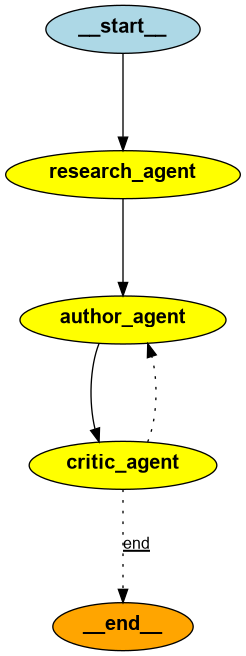

In [10]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_png()))

### Uruchom graf i wygeneruj artykuł

In [11]:
for chunk in supervisor.stream(
    {
        "messages": [{
            "role": "user",
            "content": "Wygeneruj artykuł na temat: Jak zbudować aplikację agenta 'Wydawcy' w oparciu o bibliotekę LangGraph",
        }],
        "critic_marked": False,
    },
    subgraphs=True,
):
    pretty_print_messages(chunk)


[
  [],
  {
    "research_agent": {
      "messages": [
        {
          "role": "assistant",
          "content": "Budowa aplikacji agenta 'Wydawcy' z użyciem biblioteki LangGraph wymaga kilku kroków:\n\n1. Zapoznanie się z biblioteką LangGraph: To pierwszy i najważniejszy krok, który pozwoli zrozumieć, jak działa LangGraph (źródło: github.com/mzarnecki).\n\n2. Użycie prostych skryptów Pythona do tworzenia agentów: LangGraph umożliwia tworzenie agentów za pomocą prostych skryptów Pythona, co jest idealne dla programistów, którzy chcą tworzyć niezawodne agentów AI z jasnymi przepływami sterowania i łatwymi możliwościami debugowania (źródło: youtube.com/AWS Developers).\n\n3. Wizualizacja przepływów decyzyjnych w LangGraph Studio: LangGraph Studio umożliwia wizualizację przepływów decyzyjnych agentów, co ułatwia zrozumienie ich działania i testowanie ich w czasie rzeczywistym (źródło: youtube.com/AWS Developers).\n\n4. Korzystanie z LangGraph do budowy zaawansowanych systemów agentów